In [10]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, Embedding, Flatten, Concatenate, LeakyReLU, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
import keras
import logging

In [11]:
print(tf.__version__)
print(keras.__version__)

print(tf.config.list_physical_devices('GPU'))

2.15.1
2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
# Load data
data_cleaned = pd.read_csv('../data/preprocessed_df_v2.csv')  # Update the path to your dataset

# Define columns
numeric_features = ['test_duration', 'mean_pupil_diameter', 'median_pupil_diameter', 'blinkrate', 'fixationrate', 'visual_acuity_logmar', 'age', 'education']
categorical_features = ['test_id']  # Assuming test_id is categorical

# Create transformers
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(sparse_output=False)  # Here's the adjustment

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply transformations
X_transformed = preprocessor.fit_transform(data_cleaned)
feature_names = numeric_features + [f'test_id_{i}' for i in range(X_transformed.shape[1] - len(numeric_features))]
data_prepared = pd.DataFrame(X_transformed, columns=feature_names)

data_prepared.head()

,test_duration,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,visual_acuity_logmar,age,education,test_id_0,test_id_1,test_id_2,test_id_3
0,0.003093,0.744081,0.745668,0.062773,0.536015,0.641026,0.344828,0.666667,1.0,0.0,0.0,0.0
1,0.002380,0.706491,0.710141,0.000000,0.317924,0.641026,0.344828,0.666667,0.0,1.0,0.0,0.0
2,0.008312,0.778767,0.782224,0.206982,0.355026,0.641026,0.344828,0.666667,0.0,0.0,1.0,0.0
3,0.003717,0.821982,0.825141,0.055339,0.522098,0.641026,0.344828,0.666667,0.0,0.0,0.0,1.0
4,0.004212,0.238943,0.236581,0.000000,0.260316,0.487179,0.344828,0.666667,1.0,0.0,0.0,0.0


In [13]:
# Extract real data and condition vectors
real_data = data_prepared[numeric_features].values
conditions = data_prepared[[f'test_id_{i}' for i in range(X_transformed.shape[1] - len(numeric_features))]].values
print(conditions[:10])

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [14]:
# Generator
def build_generator(latent_dim, condition_shape, output_dim):
    noise = Input(shape=(latent_dim,))
    condition = Input(shape=(condition_shape,))
    merged_layer = Concatenate()([noise, condition])
    hidden = Dense(128, activation='relu')(merged_layer)
    hidden = Dense(256, activation='relu')(hidden)
    out = Dense(output_dim, activation='linear')(hidden)
    model = Model(inputs=[noise, condition], outputs=out)
    return model

# Discriminator
def build_discriminator(input_shape, condition_shape):
    data = Input(shape=(input_shape,))
    condition = Input(shape=(condition_shape,))
    merged_layer = Concatenate()([data, condition])
    hidden = Dense(256, activation='relu')(merged_layer)
    hidden = Dense(128, activation='relu')(hidden)
    out = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=[data, condition], outputs=out)
    return model

In [15]:
# Gradient penalty loss using tf.GradientTape
def gradient_penalty_loss(discriminator, real_imgs, fake_imgs, real_conditions, batch_size, gradient_penalty_weight):
    epsilon = tf.random.uniform([batch_size, 1], 0.0, 1.0)
    interpolated_imgs = epsilon * real_imgs + (1 - epsilon) * fake_imgs
    with tf.GradientTape() as tape:
        tape.watch(interpolated_imgs)
        validity_interpolated = discriminator([interpolated_imgs, real_conditions])
    gradients = tape.gradient(validity_interpolated, [interpolated_imgs])[0]
    gradients_sqr = tf.square(gradients)
    gradient_l2_norm = tf.sqrt(tf.reduce_sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape))))
    gradient_penalty = gradient_penalty_weight * tf.square(gradient_l2_norm - 1.0)
    return tf.reduce_mean(gradient_penalty)

# Wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

In [16]:
latent_dim = 100
condition_shape = conditions.shape[1]  # Number of one-hot encoded test_id columns
output_dim = real_data.shape[1]  # Number of features the generator should output

# Configuration details
latent_dim = 100
num_tests = 4  # Number of different test_id categories

# Optimizers with adjusted learning rates
optimizer_gen = Adam(0.0001, 0.5)
optimizer_disc = Adam(0.0002, 0.5)

# Build and compile your models with these optimizers
generator = build_generator(latent_dim, condition_shape, output_dim)
discriminator = build_discriminator(output_dim, condition_shape)
discriminator.compile(loss=wasserstein_loss, optimizer=optimizer_disc, metrics=['accuracy'])

# Combined model
discriminator.trainable = False
noise_input = Input(shape=(latent_dim,))
condition_input = Input(shape=(condition_shape,))
generated_data = generator([noise_input, condition_input])
validity = discriminator([generated_data, condition_input])
combined = Model([noise_input, condition_input], validity)
combined.compile(loss=wasserstein_loss, optimizer=optimizer_gen)

In [17]:
def train(generator, discriminator, combined, data, conditions, epochs=100, batch_size=128, save_interval=10):
    # Lists to hold log of losses
    d_losses = []
    g_losses = []
    d_accuracies = []

    half_batch = batch_size // 2
    
    for epoch in range(epochs):
        for _ in range(2):  # Train discriminator more frequently
            # Train Discriminator
            idx_real = np.random.randint(0, data.shape[0], half_batch)
            real_imgs = data[idx_real]
            real_conditions = conditions[idx_real]

            noise = np.random.normal(0, 1, (half_batch, latent_dim))
            fake_imgs = generator.predict([noise, real_conditions])

            real_y = 0.9 * np.ones((half_batch, 1))  # Label smoothing for real images
            fake_y = np.zeros((half_batch, 1))

            d_loss_real = discriminator.train_on_batch([real_imgs, real_conditions], real_y)
            d_loss_fake = discriminator.train_on_batch([fake_imgs, real_conditions], fake_y)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_conditions = conditions[np.random.randint(0, conditions.shape[0], batch_size)]
        valid_y = np.ones((batch_size, 1))  # Real labels for generator training

        g_loss = combined.train_on_batch([noise, sampled_conditions], valid_y)

        # Save losses for plotting
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_accuracies.append(100 * d_loss[1])

        # Print the progress
        print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {d_loss[0]:.4f}, Acc: {100*d_loss[1]:.2f}%, Generator Loss: {g_loss:.4f}")

        # Optionally save the model
        if (epoch + 1) % save_interval == 0:
            pass
            # generator.save(f'cgan_generator_{epoch+1}.h5')
            # discriminator.save(f'cgan_discriminator_{epoch+1}.h5')

    # Plotting the training progress with dual y-axis
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(d_losses, label='Discriminator Loss', color='tab:blue')
    ax1.plot(g_losses, label='Generator Loss', color='tab:orange')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)')
    ax2.plot(d_accuracies, label='Discriminator Accuracy', color='tab:green')
    ax2.tick_params(axis='y')

    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title('Training Losses and Accuracy')
    plt.show()

1/1 [==============================] - 0s 10ms/step
Epoch 1/500, Discriminator Loss: 0.2109, Acc: 48.44%, Generator Loss: 0.4612
1/1 [==============================] - 0s 11ms/step
Epoch 2/500, Discriminator Loss: 0.2052, Acc: 50.00%, Generator Loss: 0.4389
1/1 [==============================] - 0s 10ms/step
Epoch 3/500, Discriminator Loss: 0.1973, Acc: 50.00%, Generator Loss: 0.4213
1/1 [==============================] - 0s 11ms/step
Epoch 4/500, Discriminator Loss: 0.1874, Acc: 50.00%, Generator Loss: 0.3998
1/1 [==============================] - 0s 12ms/step
Epoch 5/500, Discriminator Loss: 0.1734, Acc: 50.00%, Generator Loss: 0.3755
1/1 [==============================] - 0s 11ms/step
Epoch 6/500, Discriminator Loss: 0.1634, Acc: 50.00%, Generator Loss: 0.3538
1/1 [==============================] - 0s 11ms/step
Epoch 7/500, Discriminator Loss: 0.1509, Acc: 50.00%, Generator Loss: 0.3211
1/1 [==============================] - 0s 11ms/step
Epoch 8/500, Discriminator Loss: 0.1408, Acc:

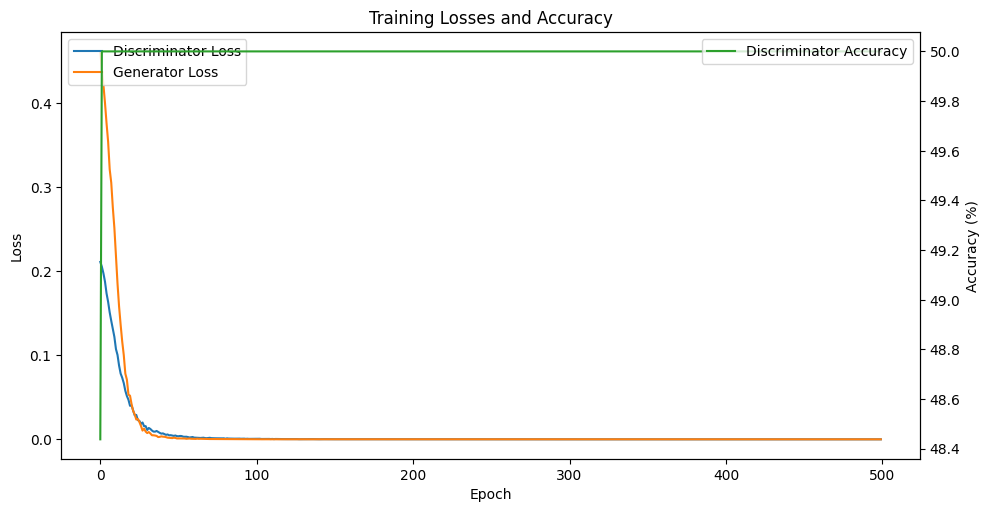

In [18]:
# Training
train(generator, discriminator, combined, real_data, conditions, epochs=500, batch_size=64)